In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pydicom
from grad_cam import GradCam
import importlib
%matplotlib inline

## Image utils

In [2]:
def load_image(file_path):
    return pydicom.dcmread(file_path)

def show_image(img, title=''):
    plt.title(title)
    plt.imshow(img.pixel_array, cmap=plt.cm.bone)
    
def show_grayscale_image(img, title=''):
    plt.title(title)
    plt.imshow(img, cmap=plt.cm.gray, vmin=0, vmax=1)

## Image processing

In [3]:
# directories
img_dir = '/data/vision/polina/projects/chestxray/work_space/labels_after_segmentation_removingLineBreaks/sub_img_v2/'
cropped_dir = img_dir + 'validation_cropped/'

# img IDs
img_id_0 = '94329_ac1beb64-51601109-19be688a-5ec49332-9cafbc3e'
img_id_1 = '94329_dd678f21-f8888fbf-dbe325fb-104c0863-1838f8e7'
img_id_2 = '77854032_0e358229-4177a691-663788e4-7fcac5db-61f2811d'
img_id_3 = '50883_77f9da94-49032e1d-9c5c5449-a6e8c9d8-e31d0999'

# viewable images
img_view_0 = os.path.join(img_dir, 'class0/' + img_id_0 + '.dcm')
img_view_1 = os.path.join(img_dir, 'class1/' + img_id_1 + '.dcm')
img_view_2 = os.path.join(img_dir, 'class2/' + img_id_2 + '.dcm')
img_view_3 = os.path.join(img_dir, 'class3/' + img_id_3 + '.dcm')

# input images for model
img_inp_0 = os.path.join(cropped_dir, 'class0/' + img_id_0 + '_cropped.npy')
img_inp_1 = os.path.join(cropped_dir, 'class1/' + img_id_1 + '_cropped.npy')
img_inp_2 = os.path.join(cropped_dir, 'class2/' + img_id_2 + '_cropped.npy')
img_inp_3 = os.path.join(cropped_dir, 'class3/' + img_id_3 + '_cropped.npy')

In [4]:
view_images = [img_view_0, img_view_1, img_view_2, img_view_3]
input_images = [img_inp_0, img_inp_1, img_inp_2, img_inp_3]

## Select image class

In [5]:
image_class = 3
img_to_feed = np.expand_dims(np.load(input_images[image_class]), 2)

## View image

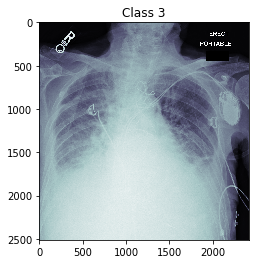

In [6]:
img_to_view = load_image(view_images[image_class])
show_image(img_to_view, "Class " + str(image_class))

## Load trained model and predict

In [7]:
# model checkpoint paths
ckpt_file = '/data/vision/polina/projects/chestxray/work_space/model_para_v8/100_30_model_classification_res_v1_4_3_maxpooling_0.05reg/model.ckpt-352985'
model_path = 'model_classification_res_v1_4_3_maxpooling'

In [8]:
sess = tf.Session()

# build model
model_module = importlib.import_module(model_path)
model = model_module.Model()
images = tf.placeholder(tf.float32, [1, img_to_feed.shape[0], img_to_feed.shape[1], 1])
train_mode = tf.placeholder(tf.bool)

model.build(images, train_mode)

# load trained model
saver = tf.train.Saver()
saver.restore(sess, ckpt_file)

# get important nodes
output = sess.graph.get_tensor_by_name('output_node:0')
conv10 = sess.graph.get_tensor_by_name('conv10_1/Conv2D:0')
pool12 = sess.graph.get_tensor_by_name('max_pool12:0')
fc13 = sess.graph.get_tensor_by_name('fc13/BiasAdd:0')
fc14 = sess.graph.get_tensor_by_name('fc14/BiasAdd:0')

conv1_1_filters
(7, 7, 1, 16)
(7, 7, 1, 16)
res2_1_filters
(5, 5, 16, 16)
(5, 5, 16, 16)
res2_2_filters
(5, 5, 16, 16)
(5, 5, 16, 16)
conv4_1_filters
(3, 3, 16, 32)
(3, 3, 16, 32)
res5_1_filters
(3, 3, 32, 32)
(3, 3, 32, 32)
res5_2_filters
(3, 3, 32, 32)
(3, 3, 32, 32)
conv7_1_filters
(3, 3, 32, 64)
(3, 3, 32, 64)
res8_1_filters
(3, 3, 64, 64)
(3, 3, 64, 64)
res8_2_filters
(3, 3, 64, 64)
(3, 3, 64, 64)
conv10_1_filters
(3, 3, 64, 128)
(3, 3, 64, 128)
res11_1_filters
(3, 3, 128, 128)
(3, 3, 128, 128)
res11_2_filters
(3, 3, 128, 128)
(3, 3, 128, 128)
fc13_weights
(2048, 256)
(2048, 256)
fc13_biases
(256,)
(256,)
fc14_weights
(256, 3)
(256, 3)
fc14_biases
(3,)
(3,)
INFO:tensorflow:Restoring parameters from /data/vision/polina/projects/chestxray/work_space/model_para_v8/100_30_model_classification_res_v1_4_3_maxpooling_0.05reg/model.ckpt-352985


In [9]:
out = sess.run(output, feed_dict={images: [img_to_feed], train_mode: False})[0]
print("output: " + str(out))

output: [0.92881054 0.85748917 0.44937566]


## Visualize using Grad-CAM

In [10]:
# construct the saliency object
grad_cam = GradCam(model, sess, output[0][0], images, conv10)

In [11]:
grad_cam_mask = grad_cam.GetMask(img_to_feed, feed_dict={train_mode: False}, should_resize = False, three_dims = False)

In [12]:
grad_cam_mask

array([[0.01231783, 0.01220882, 0.01329333, 0.01277126, 0.01046458,
        0.00584985, 0.00460364, 0.00439016, 0.00449877, 0.00530132,
        0.00874013, 0.01308684, 0.01351863, 0.01332552, 0.01296179,
        0.01110759],
       [0.00878657, 0.00776015, 0.00746007, 0.00717624, 0.00603865,
        0.00455531, 0.0038014 , 0.00371816, 0.00373719, 0.00406693,
        0.0053232 , 0.00811575, 0.00910166, 0.01117799, 0.01213066,
        0.00976579],
       [0.00609737, 0.00611722, 0.00567791, 0.00564835, 0.0054727 ,
        0.00412652, 0.00353187, 0.00345541, 0.00371448, 0.00475186,
        0.00506987, 0.00420123, 0.00450445, 0.00657973, 0.009011  ,
        0.00792897],
       [0.00608588, 0.00550055, 0.00721173, 0.007337  , 0.00611052,
        0.00418321, 0.00334385, 0.00356853, 0.00427375, 0.00551503,
        0.0067764 , 0.00621802, 0.00562247, 0.0048997 , 0.00589284,
        0.00611526],
       [0.0061131 , 0.00732451, 0.00694329, 0.00654355, 0.00505281,
        0.00378467, 0.00324484, 

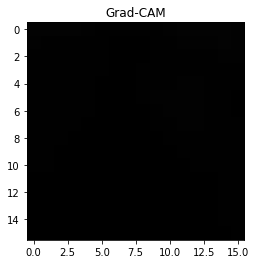

In [13]:
# render the saliency mask
show_grayscale_image(grad_cam_mask, title='Grad-CAM')

## Clean resources

In [14]:
# close session
sess.close()

## OLD STUFF

In [15]:
# restore the checkpoint
sess = tf.Session()
saver = tf.train.import_meta_graph(ckpt_meta)
# saver = tf.train.Saver()
saver.restore(sess, ckpt_file)

# access and create placeholders
# graph = tf.get_default_graph()
x = sess.graph.get_tensor_by_name('input_node:0')
out = sess.graph.get_tensor_by_name('output_node:0')
conv_layer = sess.graph.get_tensor_by_name('conv10_1/Conv2D:0')
pool_layer = sess.graph.get_tensor_by_name('max_pool12:0')
fc13_matmul = sess.graph.get_tensor_by_name('fc13/MatMul:0')
fc13_biasadd = sess.graph.get_tensor_by_name('fc13/BiasAdd:0')
fc14_matmul = sess.graph.get_tensor_by_name('fc14/MatMul:0')
fc14_biasadd = sess.graph.get_tensor_by_name('fc14/BiasAdd:0')

output: [[0.5971686  0.32665873 0.00732337]]
output: [[0.92836523 0.80424565 0.38156226]]

output: [[0.9753777  0.78754294 0.7105702 ]]
In [ ]:



SyntaxError: invalid syntax (<ipython-input-15-bdbfb15264bc>, line 18)

In [ ]:
# predict
output = sess.run(fc14_biasadd, feed_dict={x: [img]})
print("output: " + str(output))

In [ ]:
for n in sess.graph.as_graph_def().node:
    if 'batch' in n.name:
        print(n.name)

## Debugging

In [ ]:
# input
node1 = tf.gradients(conv_layer, x)
grad1 = sess.run(node1, feed_dict={x: [img]})
print(grad1)
node2 = tf.gradients(pool_layer, x)
grad2 = sess.run(node2, feed_dict={x: [img]})
print(grad2)
node3 = tf.gradients(fc13_biasadd, x)
grad3 = sess.run(node3, feed_dict={x: [img]})
print(grad3)
node4 = tf.gradients(fc14_biasadd, x)
grad4 = sess.run(node4, feed_dict={x: [img]})
print(grad4)

In [ ]:
# mid
node1 = tf.gradients(conv_layer, x)
grad1 = sess.run(node1, feed_dict={x: [img]})
print(grad1)
node2 = tf.gradients(pool_layer, conv_layer)
grad2 = sess.run(node2, feed_dict={x: [img]})
print(grad2)
node3 = tf.gradients(fc13_biasadd, pool_layer)
grad3 = sess.run(node3, feed_dict={x: [img]})
print(grad3)
node4 = tf.gradients(fc14_biasadd, fc13_biasadd)
grad4 = sess.run(node4, feed_dict={x: [img]})
print(grad4)
node5 = tf.gradients(out, fc14_biasadd)
grad5 = sess.run(node5, feed_dict={x: [img]})
print(grad5)

In [ ]:
# output
node1 = tf.gradients(out, conv_layer)
grad1 = sess.run(node1, feed_dict={x: [img]})
print(grad1)
node2 = tf.gradients(out, pool_layer)
grad2 = sess.run(node2, feed_dict={x: [img]})
print(grad2)
node3 = tf.gradients(out, fc13_biasadd)
grad3 = sess.run(node3, feed_dict={x: [img]})
print(grad3)
node4 = tf.gradients(out, fc14_biasadd)
grad4 = sess.run(node4, feed_dict={x: [img]})
print(grad4)

In [ ]:
zeros = np.zeros(img.shape)

In [ ]:
layerc = sess.run(conv_layer, feed_dict={x: [zeros]})
print("14", layerc)
conv_layerrand = np.random.random_sample(layerc[0].shape)*100000
node4 = tf.gradients(fc13_biasadd, conv_layer)
grad4 = sess.run(node4, feed_dict={conv_layer: [conv_layerrand]})
print(grad4)

In [ ]:
layer13 = sess.run(fc13_biasadd, feed_dict={x: [zeros]})
print("14", layer13)
layer13rand = np.random.random_sample(layer13[0].shape)*100000
node4 = tf.gradients(fc14_biasadd, fc13_biasadd)
grad4 = sess.run(node4, feed_dict={fc13_biasadd: [layer13rand]})
print(grad4)

In [ ]:
# ALL ZEROS
layer14 = sess.run(fc14_biasadd, feed_dict={x: [zeros]})
print("14", layer14)
layer14zeros = np.zeros(layer14[0].shape)
print(layer14zeros)
print("out", sess.run(out, feed_dict={fc14_biasadd: [layer14zeros]})[0])

In [ ]:
# ALL RANDOM
layer14 = sess.run(fc14_biasadd, feed_dict={x: [zeros]})
print("14", layer14)
layer14rand = np.random.random_sample(layer14[0].shape)*100000
print(layer14rand)
print("out", sess.run(out, feed_dict={fc14_biasadd: [layer14rand]})[0])

In [ ]:
# CLASS 0
img = np.expand_dims(np.load(img_model_0), 2)
layer13 = sess.run(fc13_biasadd, feed_dict={x: [img]})
# print(layer13)
layer14 = sess.run(fc14_biasadd, feed_dict={x: [img]})[0]
print("14", layer14)
print("out", sess.run(out, feed_dict={fc14_biasadd: [layer14]})[0])

In [ ]:
# CLASS 1
img = np.expand_dims(np.load(img_model_1), 2)
layer13 = sess.run(fc13_biasadd, feed_dict={x: [img]})
# print(layer13)
layer14 = sess.run(fc14_biasadd, feed_dict={x: [img]})[0]
print("14", layer14)
print("out", sess.run(out, feed_dict={fc14_biasadd: [layer14]})[0])

In [ ]:
# CLASS 2
img = np.expand_dims(np.load(img_model_2), 2)
layer13 = sess.run(fc13_biasadd, feed_dict={x: [img]})
# print(layer13)
layer14 = sess.run(fc14_biasadd, feed_dict={x: [img]})[0]
print("14", layer14)
print("out", sess.run(out, feed_dict={fc14_biasadd: [layer14]})[0])

In [ ]:
# CLASS 3
img = np.expand_dims(np.load(img_model_3), 2)
layer13 = sess.run(fc13_biasadd, feed_dict={x: [img]})
# print(layer13)
layer14 = sess.run(fc14_biasadd, feed_dict={x: [img]})[0]
print("14", layer14)
print("out", sess.run(out, feed_dict={fc14_biasadd: [layer14]})[0])

In [ ]:
tf.get_default_graph().get_operations()

In [ ]:
# train_writer = tf.summary.FileWriter('/data/vision/polina/projects/nn-visualization/data/tensorboard', sess.graph)

In [ ]:
# output model tensors
from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file
print_tensors_in_checkpoint_file(ckpt_file, all_tensors=True, tensor_name='fc14')

In [ ]:
# # restore the checkpoint
# sess = tf.Session()
# saver = tf.train.import_meta_graph(ckpt_meta)
# saver.restore(sess, ckpt_file)

# # access and create placeholders
# # graph = tf.get_default_graph()

# init_op = tf.initialize_all_variables()
sess = tf.Session()
# sess.run(init_op)
saver = tf.train.import_meta_graph(ckpt_meta)
saver.restore(sess, ckpt_file)
gd = sess.graph_def
inp, prediction = tf.import_graph_def(
  gd, return_elements = ['input_node:0', 'output_node:0'])
result = sess.run(prediction, feed_dict={inp: [img]})

In [ ]:
tf.reset_default_graph()
saver = tf.train.import_meta_graph(ckpt_meta)

with tf.Session() as sess:
    # restore the checkpoint
#     saver = tf.train.import_meta_graph(ckpt_meta)
#     saver.restore(sess, ckpt_file)
    saver.restore(sess, ckpt_file)

    # access and create placeholders
    # graph = tf.get_default_graph()
    x = sess.graph.get_tensor_by_name('input_node:0')
    out = sess.graph.get_tensor_by_name('output_node:0')
    conv_layer = sess.graph.get_tensor_by_name('conv10_1/Conv2D:0')
    pool_layer = sess.graph.get_tensor_by_name('max_pool12:0')
    fc13_matmul = sess.graph.get_tensor_by_name('fc13/MatMul:0')
    fc13_biasadd = sess.graph.get_tensor_by_name('fc13/BiasAdd:0')
    fc14_matmul = sess.graph.get_tensor_by_name('fc14/MatMul:0')
    fc14_biasadd = sess.graph.get_tensor_by_name('fc14/BiasAdd:0')

    # predict
    output = sess.run(out, feed_dict={x: [img]}) #[0]
    print("output: " + str(output))

In [ ]:
graph = tf.Graph()

with graph.as_default():
    images = tf.placeholder(tf.float32, shape=(1, img.shape[0], img.shape[1], img.shape[2]))

#   with slim.arg_scope(inception_v3.inception_v3_arg_scope()):
#     _, end_points = inception_v3.inception_v3(images, is_training=False, num_classes=1001)
    
    # Restore the checkpoint
    sess = tf.Session(graph=graph)
    saver = tf.train.import_meta_graph(ckpt_meta)
    saver.restore(sess, ckpt_file)
    
    # Construct the scalar neuron tensor.
    fc14_biasadd = sess.graph.get_tensor_by_name('fc14/BiasAdd:0')
    neuron_selector = tf.placeholder(tf.int32)
    y = fc14_biasadd[0][neuron_selector]

    # Construct tensor for predictions.
    prediction = tf.sigmoid(fc14_biasadd)